In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeBrooklynV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle

from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, append_inverse_to_quantum_circuit, get_circuit_for_model
from circuits.pqc_circuits import qiskit_PQC_RZRX, qiskit_PQC_RXRZ, qiskit_PQC_RXRZRY

from simulator.simulate import get_ideal_shots, run_circuit_sim, get_ideal_data

from models.qiskit_models import SimpleQiskitQuantumModel


In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    device = torch.device("mps")
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    device = torch.device("cuda")
else:
    print('Torch running on CPU')
    device = torch.device("cpu")

Torch running on Apple GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 6
# fakeVigo2_backend = FakeVigoV2()
fakeAthensV2_backend = FakeAthensV2()
fakeBrooklynV2_backend = FakeBrooklynV2()

# ideal_sim = AerSimulator()
noisy_sim = AerSimulator().from_backend(fakeBrooklynV2_backend)

pqc_arch = qiskit_PQC_RZRX

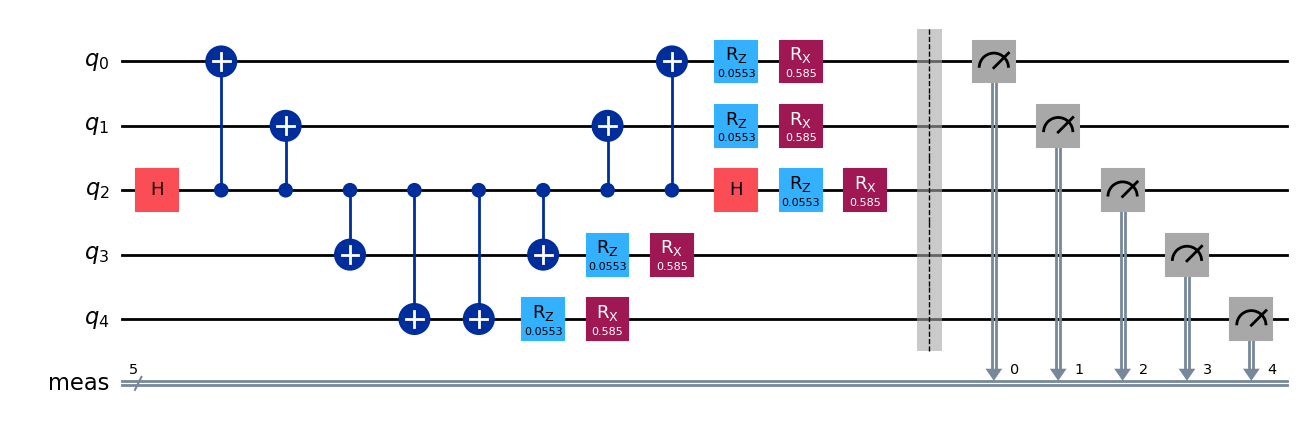

In [6]:
test_circ = append_inverse_to_quantum_circuit(custom_ghz(5, 2))
test_params = torch.rand(2)
# print(test_params)
# test_circ = test_circ.compose(test_circ.inverse())
test_circ_pqc = append_pqc_to_quantum_circuit(test_circ, test_params, pqc_arch)
test_circ_pqc.draw('mpl')

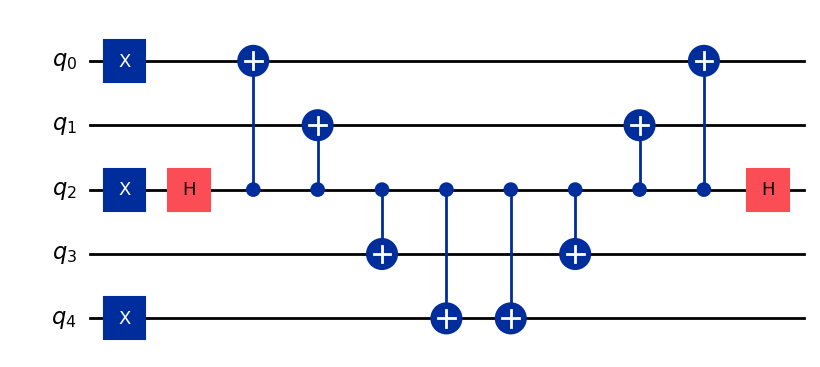

In [7]:
mcirc = get_circuit_for_model(INPUT_BITS, custom_ghz(num_q=NUM_QUBITS, hammard_on=H_ON))
mcirc.draw('mpl')

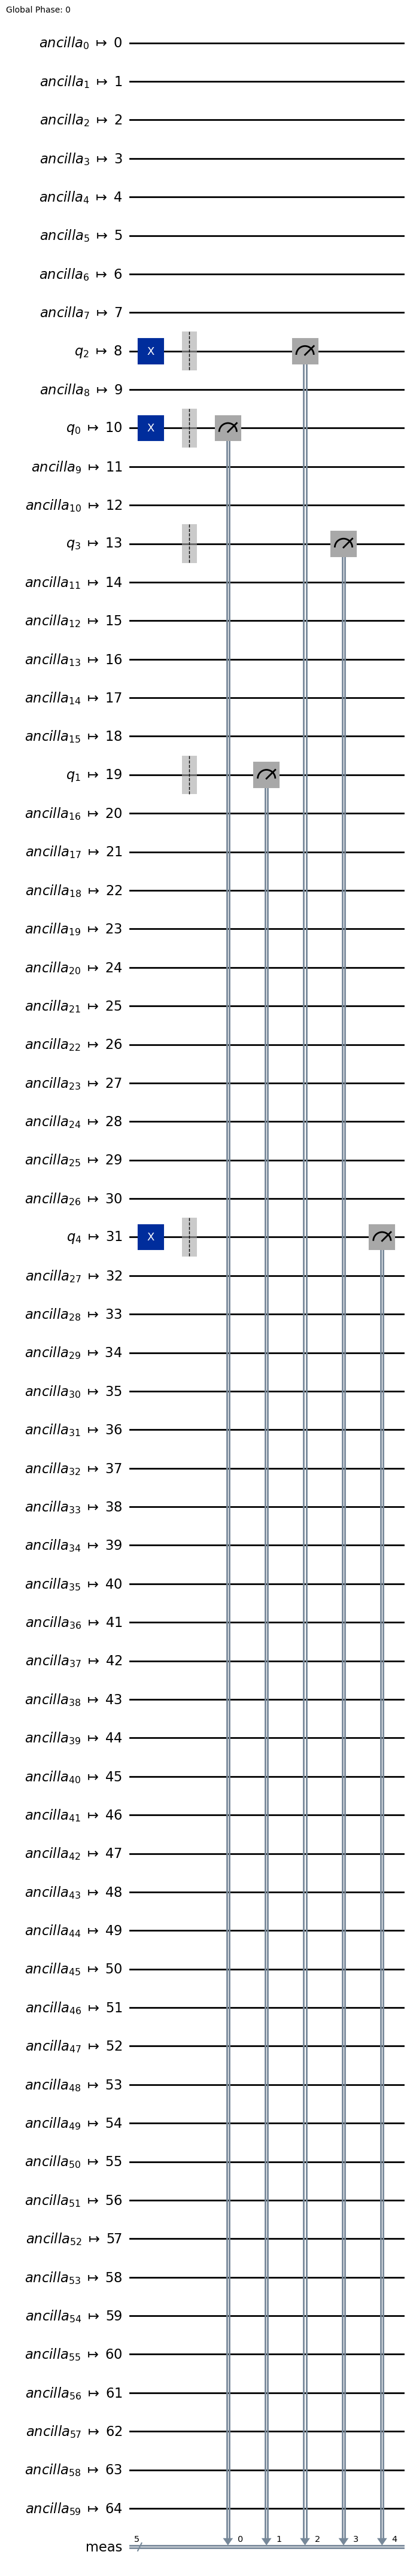

In [8]:
mcirc_measured = mcirc.measure_all(inplace=False)
transpiled_circ = transpile(mcirc_measured, noisy_sim)
transpiled_circ.draw('mpl')

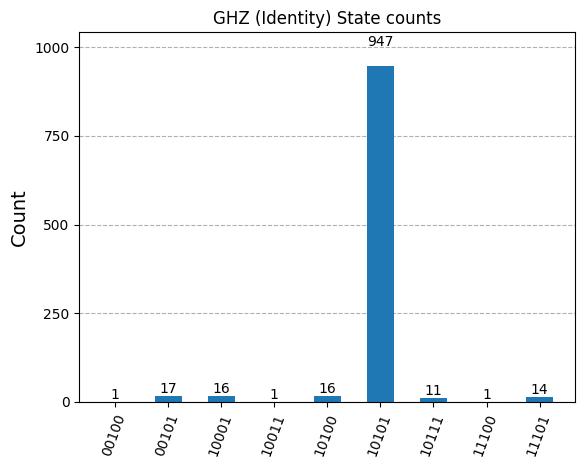

In [9]:
result = noisy_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)
plot_histogram(counts, title='GHZ (Identity) State counts')

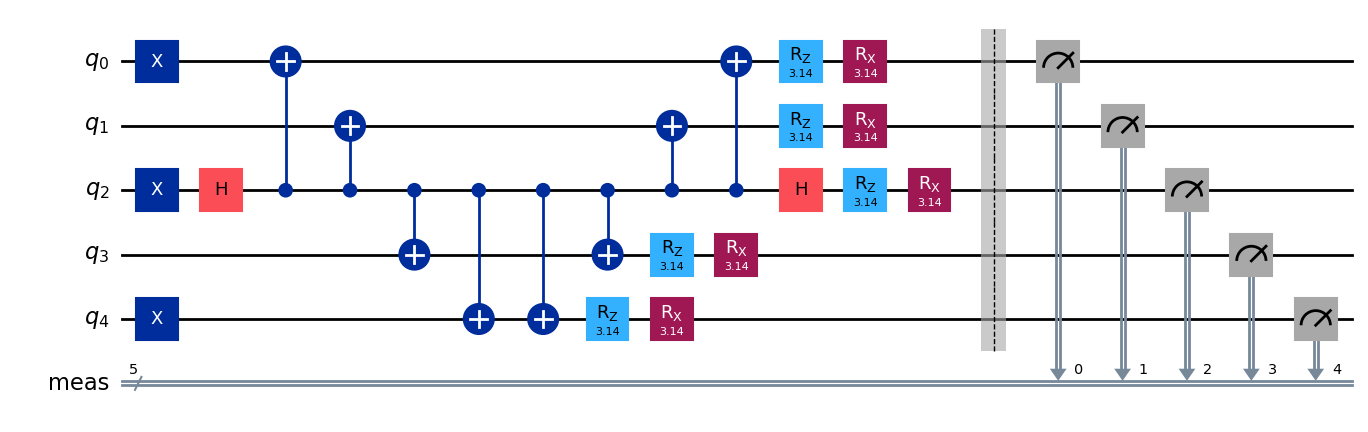

In [10]:
mcirc_pqc = append_pqc_to_quantum_circuit(mcirc, torch.full((2,), torch.pi), pqc_arch)
mcirc_pqc.draw('mpl')

# Loss Function, followed by Model

In [11]:
# def fidelity_from_counts(counts_a, counts_b, n_a, n_b, eps=1e-9):
#     keys = sorted(set(counts_a) | set(counts_b))
#     pa = torch.tensor([counts_a.get(k,0)/n_a + eps for k in keys])
#     pb = torch.tensor([counts_b.get(k,0)/n_b + eps for k in keys])
#     return torch.square(torch.sum(torch.sqrt(pa*pb)))


class QuantumFidelityLoss(nn.Module):
    def __init__(self, num_shots):
        super(QuantumFidelityLoss, self).__init__()
        self.num_counts = num_shots
    
    def forward(self, ideal:torch.Tensor, measured:torch.Tensor, eps: float = 1e-8):
        """
        Classical fidelity  F(P,Q) = (Σ√(p_i q_i))²
        Loss  = 1 - F.
        Both inputs are 1-D tensors of equal length whose elements represent the "counts" of the measured state at their respective index. 
        """
        # --- smoothing & normalisation ---------------------------------
        p = ideal / self.num_counts + eps         # avoid √0 and log0 issues
        q = measured / self.num_counts + eps
        
        # print('Ideal: ', ideal)
        # print('p: ', p)
        # print('Measured: ', measured)
        # print('q: ', q)
        
        
        p = p / p.sum()
        q = q / q.sum()

        # print(p.sum(), q.sum())

        # Over here, p.sum and q.sum should be 1.0


        fidelity = torch.square(torch.sum(torch.sqrt(p * q)))     # Bhattacharyya coefficient
        # fidelity = bc ** 2                    # square → classical fidelity
        return 1.0 - fidelity                 # minimise this

        


In [12]:
ideal_data = get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

32


In [13]:
ghz_circuit = custom_ghz(NUM_QUBITS, H_ON)
pqc_model = SimpleQiskitQuantumModel(num_params=2, simulator=noisy_sim, 
                                     num_shots=NUM_SHOTS, base_circuit=ghz_circuit,
                                     pqc_arch_func=pqc_arch)

optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)


# loss_fn = nn.MSELoss()
# loss_fn = nn.KLDivLoss(reduction='batchmean')
loss_fn = QuantumFidelityLoss(num_shots=NUM_SHOTS)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

print(device)

mps


In [14]:
param_list = []
loss_list_epoch = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    loss_list = [0]
    shuffle(ideal_data)
    data_iterator_tqdm = tqdm(ideal_data)
    for bitstring, ideal in data_iterator_tqdm:
        ctr += 1
        optimizer.zero_grad()

        measured = pqc_model(circuit=get_circuit_for_model(bitstring, ghz_circuit))
        ideal = ideal.float().to(device)
        measured = measured.float().to(device)
        
        loss = loss_fn(ideal=ideal, measured=measured)

        loss.backward()
        optimizer.step()

        param_values = pqc_model.pqc_params.detach().cpu().numpy().copy()
        param_list.append(param_values)
        loss_list.append(loss.item())
        data_iterator_tqdm.set_postfix_str(f"Loss: {loss} \t Params: {param_values}")
        # print(param_list)


        # if (ctr) % (len(ideal_data) // 10) == 0:
            
    print(f'Loss: {np.mean(loss_list):.4f}, Params: {pqc_model.pqc_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')
    loss_list_epoch.append(np.mean(loss_list))

    

Starting Epoch 1


100%|██████████| 1000/1000 [2:43:58<00:00,  9.84s/it, Loss: 0.06922274827957153 	 Params: [0.00649573 0.02090201]]    


Loss: 0.8254, Params: Parameter containing:
tensor([0.0065, 0.0209], requires_grad=True)
Starting Epoch 2


100%|██████████| 1000/1000 [6:25:52<00:00, 23.15s/it, Loss: 0.9999999403953552 	 Params: [4.3222572e-05 1.3908188e-04]]    


Loss: 0.7586, Params: Parameter containing:
tensor([4.3223e-05, 1.3908e-04], requires_grad=True)
Starting Epoch 3


100%|██████████| 1000/1000 [2:07:46<00:00,  7.67s/it, Loss: 0.9999999403953552 	 Params: [2.8760334e-07 9.2545059e-07]]     


Loss: 0.7587, Params: Parameter containing:
tensor([2.8760e-07, 9.2545e-07], requires_grad=True)
Starting Epoch 4


100%|██████████| 1000/1000 [11:18<00:00,  1.47it/s, Loss: 0.0643385648727417 	 Params: [1.9137121e-09 6.1579577e-09]]     


Loss: 0.7585, Params: Parameter containing:
tensor([1.9137e-09, 6.1580e-09], requires_grad=True)
Starting Epoch 5


100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s, Loss: 0.9999999403953552 	 Params: [1.2733827e-11 4.0975015e-11]]   


Loss: 0.7581, Params: Parameter containing:
tensor([1.2734e-11, 4.0975e-11], requires_grad=True)
Starting Epoch 6


100%|██████████| 1000/1000 [26:19<00:00,  1.58s/it, Loss: 0.059454381465911865 	 Params: [8.4730786e-14 2.7264793e-13]]  

Loss: 0.7581, Params: Parameter containing:
tensor([8.4731e-14, 2.7265e-13], requires_grad=True)


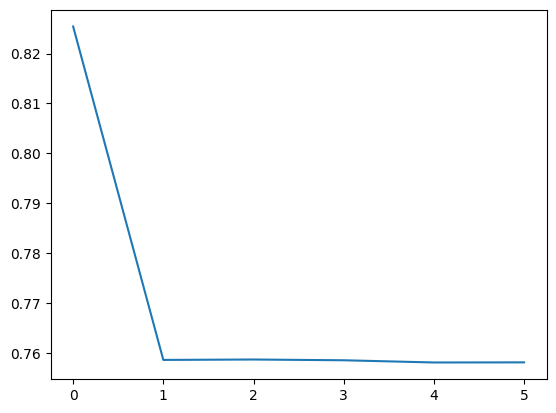

In [15]:
plt.plot([i for i in range(len(loss_list_epoch))], loss_list_epoch)
plt.show()

In [16]:
param_arr = np.array(param_list).transpose()
print(param_arr)

[[9.7133350e-01 9.6647686e-01 9.6164447e-01 ... 8.5584487e-14
  8.5156566e-14 8.4730786e-14]
 [3.1255641e+00 3.1099362e+00 3.0943866e+00 ... 2.7539497e-13
  2.7401800e-13 2.7264793e-13]]


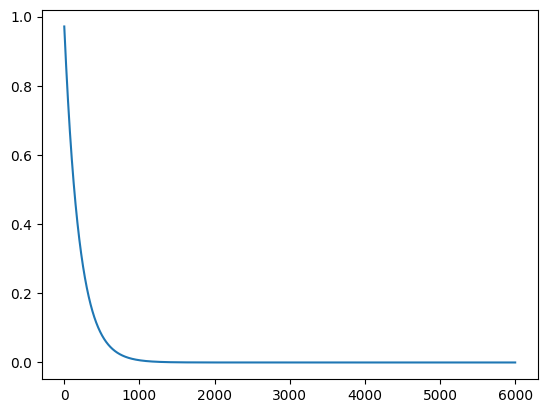

In [17]:
plt.plot([i for i in range(param_arr.shape[1])], param_arr[0])
plt.show()

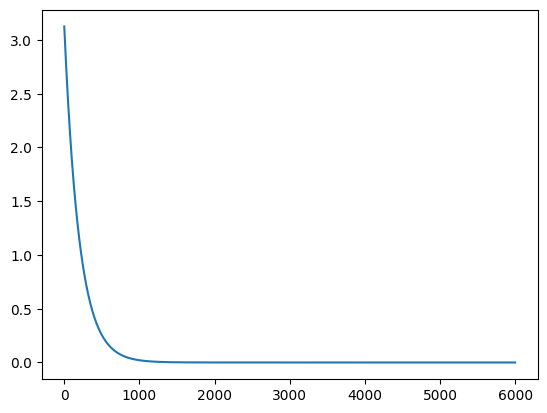

In [18]:
plt.plot([i for i in range(param_arr.shape[1])], param_arr[1])
plt.show()

In [19]:
pqc_model.pqc_params

Parameter containing:
tensor([8.4731e-14, 2.7265e-13], requires_grad=True)

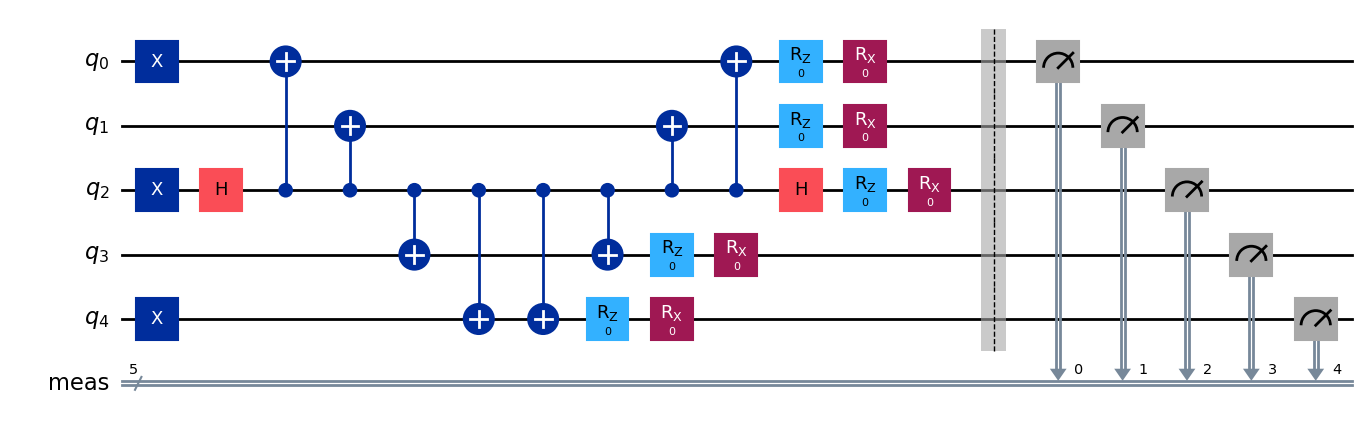

In [20]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params, pqc_arch)
mcirc_post.draw('mpl')

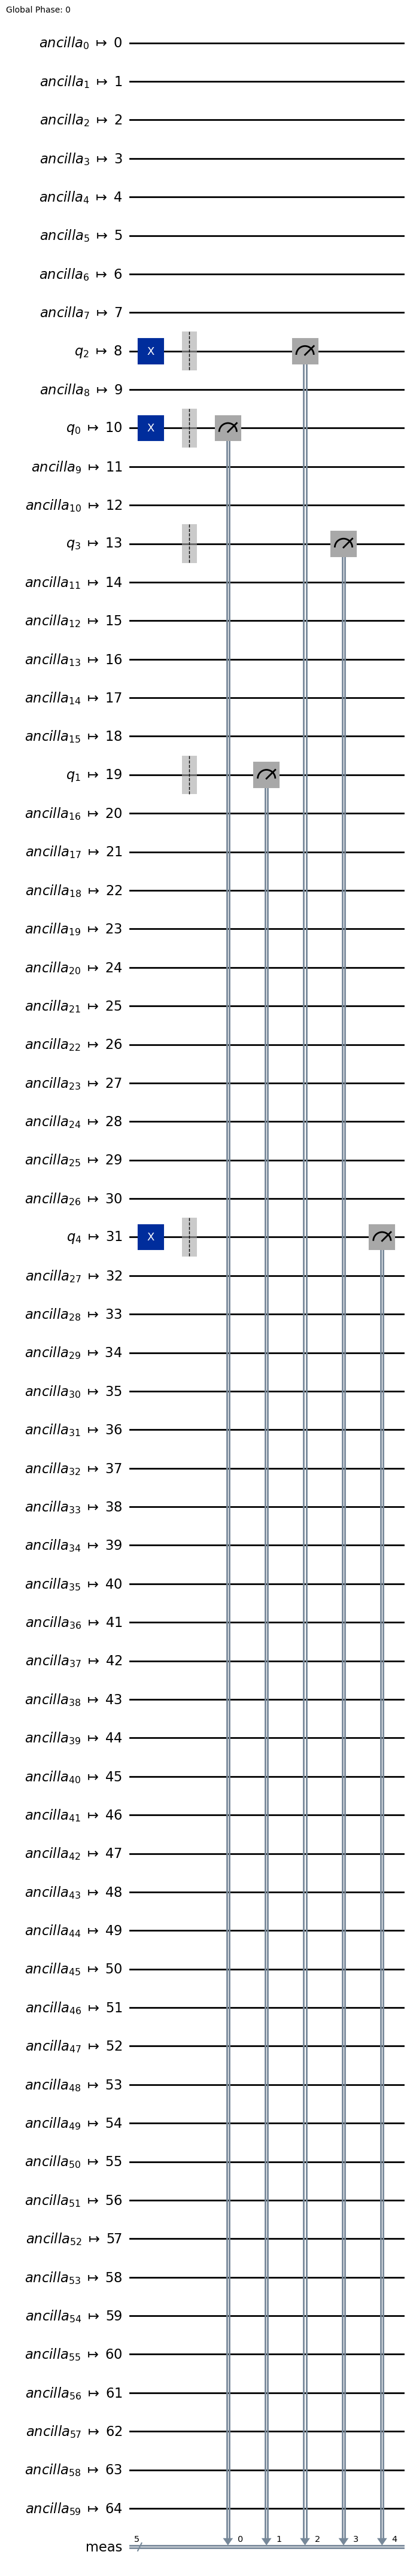

In [21]:

transpiled_circ = transpile(mcirc_post, noisy_sim)
transpiled_circ.draw('mpl')

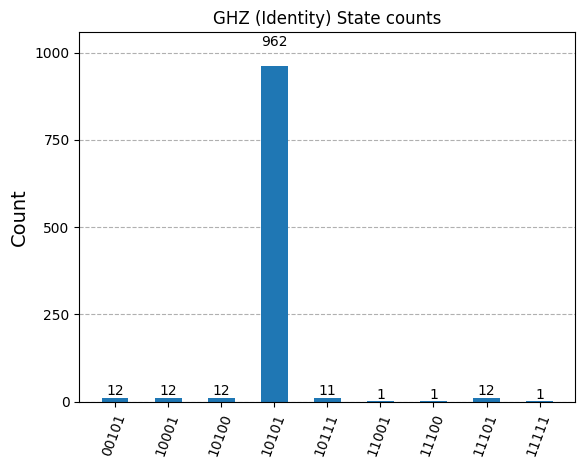

In [22]:
result = noisy_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

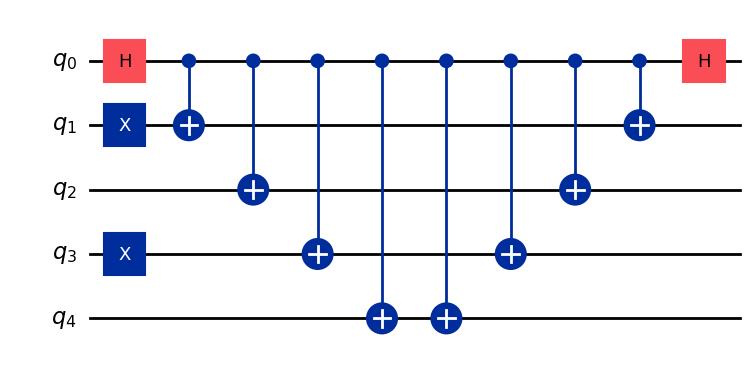

In [23]:
mcirc = get_circuit_for_model('01010', custom_ghz(NUM_QUBITS,0))
mcirc.draw('mpl')

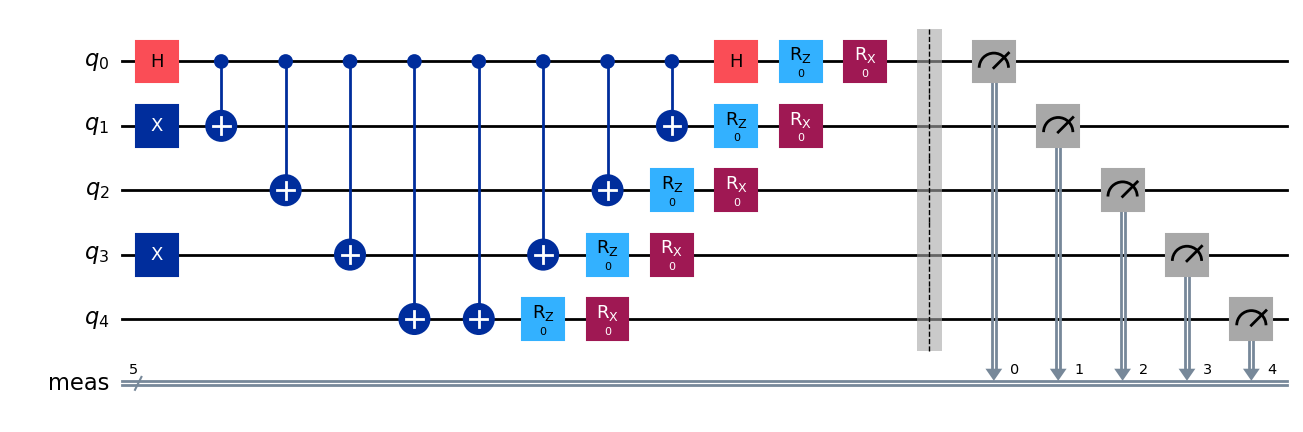

In [24]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params, pqc_arch)
mcirc_post.draw('mpl')

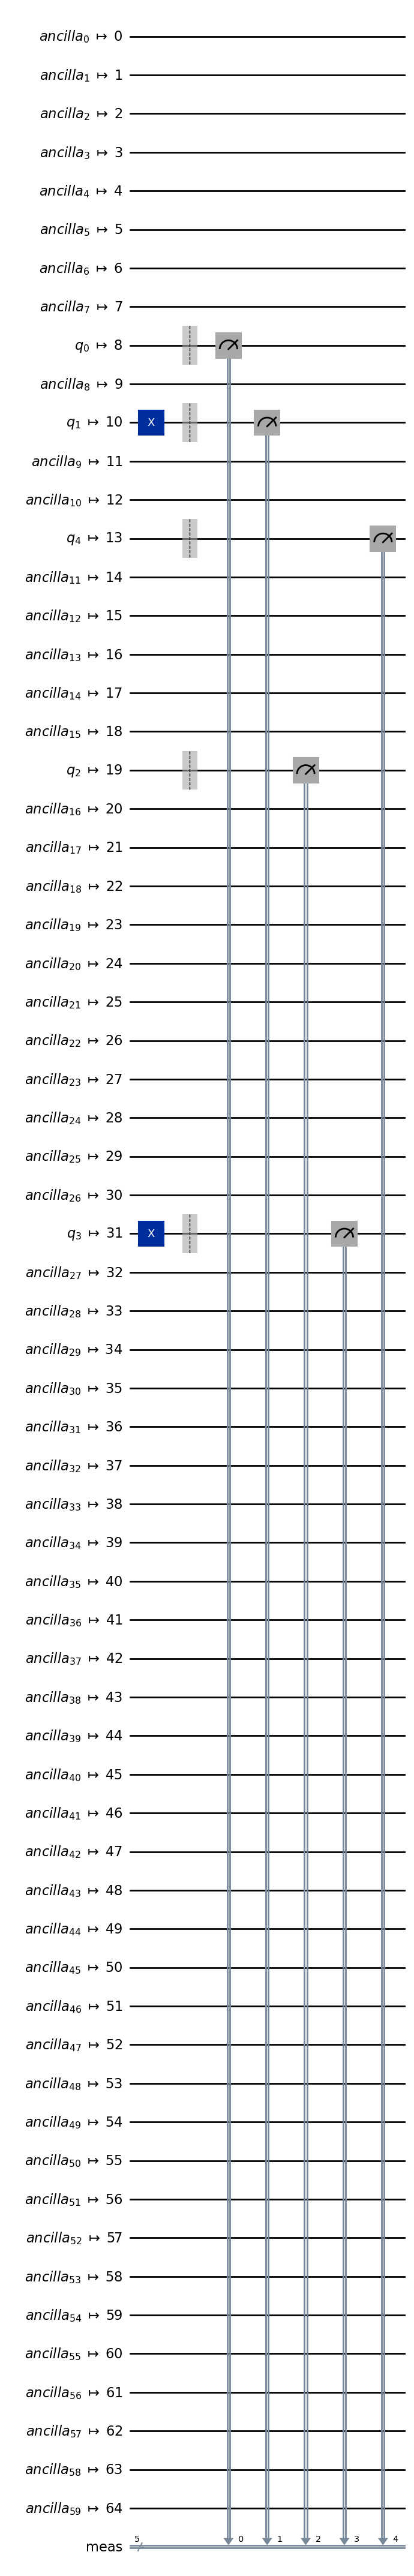

In [25]:
transpiled_circ = transpile(mcirc_post, noisy_sim)
transpiled_circ.draw('mpl')

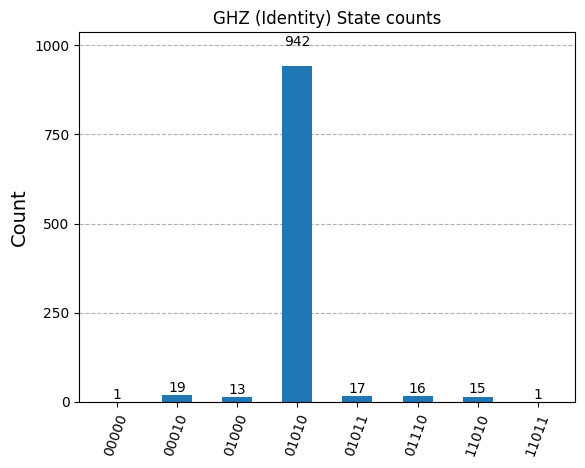

In [26]:
result = noisy_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')